<a href="https://colab.research.google.com/github/anjurgupta/Energy-Lab-Codes/blob/main/Energy_Lab_4_1_Forced_Convetion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Section 1: Import Required Libraries**

*We will start by importing the Python libraries that help us build and train machine learning models, handle data, and create plots for visualization.*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import preprocessing layers needed
from tensorflow.keras.layers import Normalization, TextVectorization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import datetime
from google.colab import files

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

**Section 2: Upload and Load Dataset**

*In this step, we will upload a dataset into our Colab environment and load it into Python. After that, we’ll take a quick look at the data to understand what it contains.*

In [2]:
uploaded = files.upload()  # Upload 'forced_convection_data.csv'


Saving forced_convection_data.csv to forced_convection_data.csv


In [3]:
data = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

**Section 3: Define Inputs and Outputs**

*Now, we will identify the input features (the data the model will use to make predictions) and the output labels (what we want the model to predict). This is an important step for setting up a supervised machine learning task.*

In [4]:
# Define input and output columns
numeric_inputs = ["To", "Trod"]      # Numeric features
categorical_input = ["Speed"]        # Text/categorical feature
output_col = ["h"]                    # Target label

**Section 4: Split Data into Training and Test Sets**

*Next, we will divide our dataset into training and testing sets. The training set is used to teach the model, while the testing set is used to see how well the model performs on new, unseen data. This helps us evaluate the model’s accuracy and reliability.*

In [5]:
# Split dataset into training (80%) and testing (20%)
train_dataset = data.sample(frac=0.8, random_state=42)
test_dataset = data.drop(train_dataset.index)

**Section 5: Normalize Data**

*Neural networks work better when all input features are on a similar scale. Normalization rescales the data so that values are neither too big nor too small. This helps the model learn faster, converge more reliably, and avoid giving more importance to features just because they have larger numbers.*

In [6]:
# --- Inspect your columns ---
print("Columns in the dataset:", data.columns.tolist())

# --- Automatically separate numeric and categorical features ---
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = data.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# --- Split dataset into training (80%) and testing (20%) ---
train_dataset = data.sample(frac=0.8, random_state=42)
test_dataset = data.drop(train_dataset.index)

# --- Training stats for numeric normalization ---
train_stats = train_dataset[numeric_cols].describe().transpose()

# --- Normalize numeric features ---
def normalize_numeric(df):
    return (df - train_stats['mean']) / train_stats['std']

normed_train_numeric = normalize_numeric(train_dataset[numeric_cols])
normed_test_numeric = normalize_numeric(test_dataset[numeric_cols])

# --- Handle categorical features using one-hot encoding ---
train_cat = pd.get_dummies(train_dataset[categorical_cols])
test_cat = pd.get_dummies(test_dataset[categorical_cols])

# --- Ensure test set has same columns as train set ---
test_cat = test_cat.reindex(columns=train_cat.columns, fill_value=0)

# --- Combine numeric and categorical features ---
normed_train_data = pd.concat([normed_train_numeric, train_cat], axis=1)
normed_test_data = pd.concat([normed_test_numeric, test_cat], axis=1)

# --- Separate labels ---
output_col = ["h"]  # heat transfer coefficient
train_labels = train_dataset[output_col]
test_labels = test_dataset[output_col]

# --- Display normalized and processed data ---
print("Processed train data (first 5 rows):")
print(normed_train_data.head())
print("\nProcessed test data (first 5 rows):")
print(normed_test_data.head())


Columns in the dataset: ['To', 'Trod', 'Speed', 'h']
Numeric columns: ['To', 'Trod', 'h']
Categorical columns: ['Speed']
Processed train data (first 5 rows):
           To      Trod         h  Speed_H  Speed_L  Speed_M
361  0.121168  1.272974  0.146530     True    False    False
73   0.945153  1.517214  1.076195    False     True    False
374  1.185410  1.416262 -0.156396     True    False    False
155  1.549391  0.225090 -0.107095    False    False     True
104 -0.932063 -1.133812  1.478933     True    False    False

Processed test data (first 5 rows):
          To      Trod         h  Speed_H  Speed_L  Speed_M
1  -0.328628 -0.236304 -0.105176     True    False    False
13  1.066259  1.058359  0.003969     True    False    False
20  0.251746  0.823021 -1.549599    False     True    False
21 -1.398020  1.214935 -0.388658    False     True    False
34 -1.054344 -1.098850  0.468468     True    False    False


**Section 6: Build the Model**

*Now we will create our neural network. A neural network is made up of layers of neurons that process the input data. Each layer uses an activation function to help the network learn complex patterns. We’ll define the input layer (which takes our features), any hidden layers (which process the information), and the output layer (which makes predictions).*

In [10]:
num_inputs = normed_train_data.shape[1]  # automatically 5 or 9 depending on your numeric + one-hot
num_outputs = 1  # since 'h' is a single target

baseline_model = keras.Sequential([
    layers.Input(shape=(num_inputs,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_outputs)  # 5 outputs
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
baseline_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

**Section 7: Define Callback and Training Parameters**

*Before training the model, we define training parameters like the number of epochs (how many times the model will see the full dataset) and callbacks (tools that help monitor or control training, like stopping early if the model stops improving). These settings help the model train efficiently and avoid overfitting.*

In [11]:
# Callback to print progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

**Section 8: Example Prediction Before Training**

*Before we train the model, we can make a test prediction using random, untrained weights. This shows that initially, the model’s predictions are basically random and not accurate. It helps you understand how much the model improves after training.*

In [14]:
example_batch = normed_train_data.head(5).astype(np.float32).values
example_result = baseline_model.predict(example_batch)
print("Example predictions (h for 1 output):")
print(example_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Example predictions (h for 1 output):
[[0.173]
 [0.171]
 [0.111]
 [0.181]
 [0.118]]


**Section 9: Setup TensorBoard**

*TensorBoard is a tool that lets us visualize and monitor our model’s training in real time. We can track metrics like loss and accuracy, see how the model improves over epochs, and spot problems early. Setting it up helps us understand what’s happening inside the neural network as it learns.*

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Section 10: Train the Model**

*Now we will train (fit) the model on our data. During training, the model learns the patterns in the input features to make better predictions. We can also use a validation split to check the model’s performance on unseen data while training, and callbacks to monitor progress or stop training early if needed. This step is where the model actually “learns.”*

In [17]:
history = baseline_model.fit(
    normed_train_data,          # numeric + one-hot features
    train_labels.values,       # corresponding outputs as numpy array
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[tensorboard_callback, PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

**Section 11: Plot Training History**

*After training, we can visualize the model’s learning curves using metrics like MAE (Mean Absolute Error) and MSE (Mean Squared Error). These plots show how the model’s predictions improve over time and help us understand if the model is learning well or if it might be overfitting.*

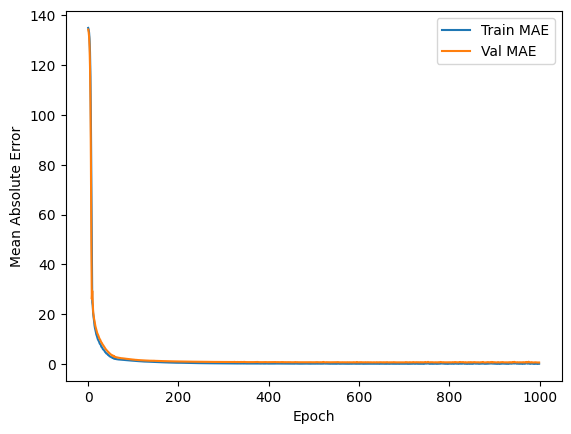

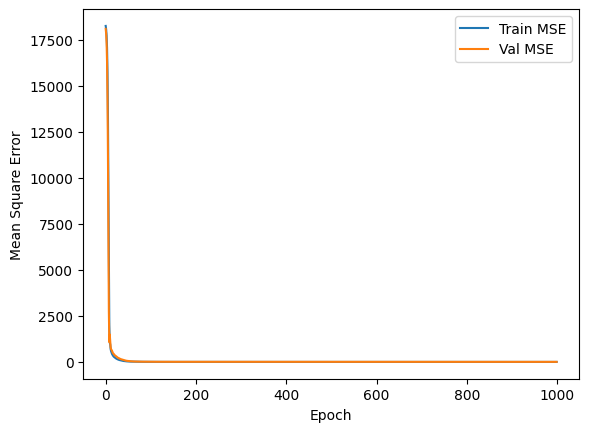

In [18]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # MAE
    plt.figure()
    plt.plot(hist['epoch'], hist['mae'], label='Train MAE')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

    # MSE
    plt.figure()
    plt.plot(hist['epoch'], hist['mse'], label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

plot_history(history)

**Section 12: Test Predictions and Scatter Plot**

*Finally, we will use the model to make predictions on the test data and compare them to the actual values. We can create a scatter plot to visualize how close the predictions are to the true values. This helps us see the model’s performance in a clear, visual way.*

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


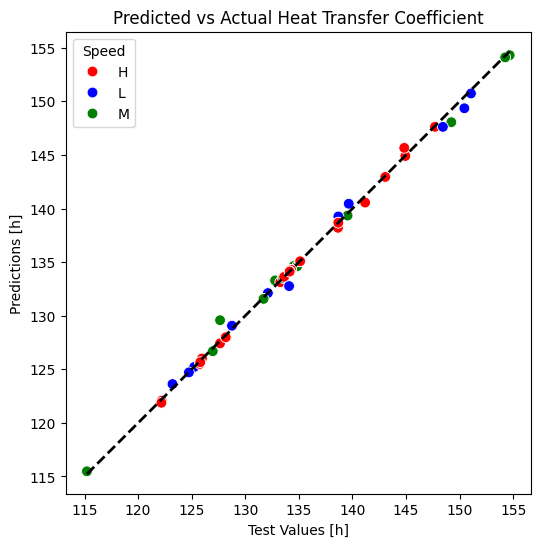

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions on test data
X_test = normed_test_data.astype(np.float32).values  # ensure numeric dtype
baseline_test_predictions = baseline_model.predict(X_test)

# Combine predictions with Speed for plotting
plot_df = test_dataset.copy()
plot_df['h_pred'] = baseline_test_predictions[:, 0]  # predicted heat transfer coefficient

plt.figure(figsize=(6,6))
sns.scatterplot(
    x='h',
    y='h_pred',
    hue='Speed',
    data=plot_df,
    palette={'H':'red', 'M':'green', 'L':'blue'},
    s=60
)

plt.xlabel("Test Values [h]")
plt.ylabel("Predictions [h]")
plt.title("Predicted vs Actual Heat Transfer Coefficient")
plt.axis('equal')

# 1:1 reference line
min_val = min(plot_df['h'].min(), plot_df['h_pred'].min())
max_val = max(plot_df['h'].max(), plot_df['h_pred'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.show()



**Section 13: Prediction Error Histograms**

*We can also look at histograms of the prediction errors (the differences between predicted and actual values). This helps us see where the model is making bigger mistakes and understand its strengths and weaknesses for each output.*

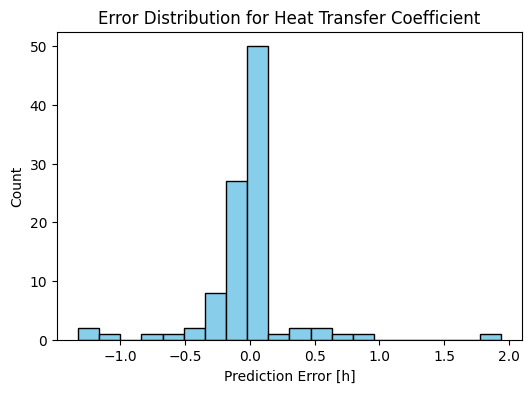

In [22]:
# Compute prediction error
baseline_error = baseline_test_predictions[:, 0] - test_dataset['h'].values

# Plot error histogram
plt.figure(figsize=(6,4))
plt.hist(baseline_error, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error [h]")
plt.ylabel("Count")
plt.title("Error Distribution for Heat Transfer Coefficient")
plt.show()